# Configuration

In [451]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import string
import cv2


NB_CHAR = 5 
SYMBOLS = string.ascii_lowercase + "0123456789"
NB_SYMBOLS = len(SYMBOLS)

MAX_EPOCH = 150
DATA_DIR = "./dataset" 
SAVE_PATH = "./saved/checkpoint_model"
TRAIN_MODE = 0 # Put 1 if you want to retrain the model
RECOGNIZED_CAPTCHAS_TO_DISPLAY = 5

In [505]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Loading and preprocessing data

## 1. Data Augmentation 

In [454]:
def preprocess_image(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced_image = clahe.apply(image)
    blurred_image = cv2.GaussianBlur(contrast_enhanced_image, (5, 5), 0)
    sharpened_image = cv2.addWeighted(blurred_image, 1.5, blurred_image, -0.5, 0)
    _, binary_image = cv2.threshold(sharpened_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binary_image

## 2. Load data

In [456]:
def load_data(data_dir=DATA_DIR):
    data = []
    labels = []
    
    captcha_images = os.listdir(data_dir)
    for captcha_image in captcha_images:
        # To avoid the .ipynb_checkpoints file
        if not "checkpoint" in captcha_image :
            image_path = os.path.join(data_dir, captcha_image)
            # Raw image 
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Preprocess image
            image_preprocess = preprocess_image(image_path)

            if image is not None :
                # Normalization
                image = image / 255.0
                image_preprocess = image_preprocess / 255.0

                # Add a dimension for the channel (1 for gray scale)
                image = np.expand_dims(image, axis=-1)
                image_preprocess = np.expand_dims(image_preprocess, axis =-1)

                #(ex : 'ABCDE.png' => 'ABCDE')
                label = captcha_image.split('.')[0]

                data.append(image)
                labels.append(label)
                data.append(image_preprocess)
                labels.append(label)

    return np.array(data), np.array(labels)

data, labels = load_data(data_dir=DATA_DIR)

## 3. Show images

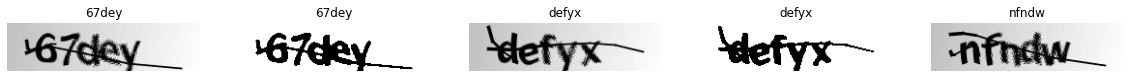

In [458]:
def show_images_with_labels(images, labels, n=5):
    fig=plt.figure(figsize=(20, 5))
    for i in range(n):
        fig.add_subplot(1, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

    
show_images_with_labels(data,labels)

## 4. Encode labels in one hot encoding 

In [460]:
def preprocess_labels(labels):
    # Each characters are convert into SYMBOLS index
    y = np.array([[SYMBOLS.find(char) for char in captchas] for captchas in labels])
    # Convert in one hot encoding
    return to_categorical(y, num_classes=NB_SYMBOLS)

In [461]:
X = data
y = preprocess_labels(labels)

print(X.shape)
print(y.shape)

(2140, 50, 200, 1)
(2140, 5, 36)


## 5. Creation of the training & test dataset

In [463]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

print("X_train shape :",X_train.shape)
print("y_train shape :",y_train.shape)
print("X_test shape :",X_test.shape)
print("y_test shape :",y_test.shape)

X_train shape : (1712, 50, 200, 1)
y_train shape : (1712, 5, 36)
X_test shape : (428, 50, 200, 1)
y_test shape : (428, 5, 36)


# Model creation and training

## 1. Creation of the recognition model 

In [465]:
def create_model():
    model = models.Sequential()
    
    model.add(layers.Input(shape=(50, 200, 1)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NB_CHAR*NB_SYMBOLS, activation='softmax'))
    model.add(layers.Reshape((NB_CHAR, NB_SYMBOLS)))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 50, 200, 32)       320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 25, 100, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 25, 100, 64)       18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 50, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 13, 50, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 7, 25, 128)       

## 2. Train the model and save the best

In [468]:
def train_model(model, X_train, y_train):
    checkpoint_filepath = SAVE_PATH

    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    callbacks = [
        model_checkpoint_callback
    ]
    hist = model.fit(X_train, y_train, epochs=MAX_EPOCH, batch_size=32, validation_split=0.1, callbacks=callbacks)
    return hist 

## 3. Plot the learning curve

In [470]:
def learning_curve(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model acc')
    plt.ylabel('CTC acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

## 4. Loading the best model

In [472]:
if TRAIN_MODE == 1 :
        hist = train_model(model, X_train, y_train)
        learning_curve(hist)
        
model = load_model(SAVE_PATH)

# Model predictions

## 1. Get predictions

In [475]:
y_pred = model.predict(X_test)
print(y_pred)

14/14 [==============================] - 11s 769ms/step
[[[4.50368452e-06 7.05845328e-03 2.63636117e-03 ... 3.32343532e-03
   5.51191275e-04 2.08998936e-05]
  [3.14510999e-06 4.18930221e-03 8.28081667e-02 ... 3.92125826e-03
   1.15789762e-02 9.07136382e-06]
  [5.19348669e-06 2.21508695e-03 3.24555114e-02 ... 6.40615169e-03
   2.64295302e-02 2.23258012e-05]
  [2.82382734e-06 6.68766908e-03 5.41472668e-03 ... 6.51483145e-03
   3.01717520e-02 3.58049442e-06]
  [1.02935337e-05 1.33958971e-02 9.24388785e-03 ... 2.17342330e-03
   1.26244705e-02 4.07110338e-06]]

 [[7.61018271e-08 1.77734848e-02 2.84614023e-02 ... 1.84071634e-03
   5.83730964e-03 1.20907742e-07]
  [4.18110432e-07 1.86574832e-02 3.23732453e-03 ... 6.05108682e-04
   1.13990344e-01 2.32475074e-07]
  [7.81677898e-07 2.24556923e-02 1.35659855e-02 ... 3.01534339e-04
   3.41358110e-02 5.85567534e-07]
  [1.03187290e-06 8.15708749e-03 3.49379219e-02 ... 4.44566365e-03
   7.22092297e-03 1.39247987e-07]
  [3.65236872e-07 1.60380953e-03 

## 2. Reverse one hot encoding

In [477]:
def reverse_OHE(y):
    samples = []
    for captchas in y :
        indexes = []
        for character_predictions in captchas:
            indexes.append(np.argmax(character_predictions))
        samples.append(indexes)
    return samples

def tuple_reverse_OHE(y_test, y_pred):
    return reverse_OHE(y_pred),reverse_OHE(y_test)

y_test_t, y_pred_t = tuple_reverse_OHE(y_test,y_pred)
print(y_pred_t)

[[23, 2, 5, 34, 34], [1, 34, 30, 23, 2], [15, 12, 5, 31, 22], [22, 6, 32, 28, 31], [28, 1, 6, 30, 34], [2, 24, 29, 13, 22], [3, 34, 3, 2, 4], [15, 12, 3, 29, 22], [28, 28, 32, 12, 3], [33, 1, 1, 33, 1], [6, 22, 13, 31, 29], [13, 30, 2, 15, 24], [28, 2, 6, 24, 23], [31, 24, 22, 22, 5], [4, 13, 13, 33, 13], [34, 34, 1, 6, 23], [31, 23, 33, 23, 31], [12, 1, 5, 31, 34], [13, 4, 4, 2, 3], [15, 6, 28, 24, 23], [22, 34, 5, 29, 32], [32, 22, 6, 30, 13], [15, 28, 23, 33, 23], [12, 31, 12, 4, 6], [3, 13, 31, 3, 5], [5, 24, 22, 1, 34], [12, 34, 12, 30, 23], [13, 3, 31, 22, 6], [22, 30, 2, 13, 13], [30, 4, 23, 13, 13], [15, 32, 12, 13, 34], [13, 6, 32, 24, 15], [5, 13, 2, 13, 1], [31, 13, 15, 30, 12], [34, 31, 32, 28, 28], [32, 1, 3, 13, 31], [33, 33, 29, 34, 33], [30, 13, 29, 12, 13], [3, 1, 5, 4, 13], [12, 29, 1, 31, 15], [6, 3, 34, 5, 1], [15, 24, 5, 32, 31], [33, 6, 29, 13, 5], [13, 34, 15, 5, 4], [30, 33, 30, 5, 5], [31, 32, 12, 32, 24], [15, 22, 4, 1, 12], [13, 6, 13, 28, 32], [29, 29, 1, 28

## 3. Predictions flattening 

In [479]:
def tuple_flatten(y_test, y_pred):
    y_test_flat = [index for sublist in y_test for index in sublist]
    y_pred_flat = [index for sublist in y_pred for index in sublist]
    return  y_test_flat, y_pred_flat

y_test_flat, y_pred_flat = tuple_flatten(y_test_t,y_pred_t)
print(y_pred_flat)

[23, 2, 5, 34, 34, 1, 34, 30, 23, 2, 15, 12, 5, 31, 22, 22, 6, 32, 28, 31, 28, 1, 6, 30, 34, 2, 24, 29, 13, 22, 3, 34, 3, 2, 4, 15, 12, 3, 29, 22, 28, 28, 32, 12, 3, 33, 1, 1, 33, 1, 6, 22, 13, 31, 29, 13, 30, 2, 15, 24, 28, 2, 6, 24, 23, 31, 24, 22, 22, 5, 4, 13, 13, 33, 13, 34, 34, 1, 6, 23, 31, 23, 33, 23, 31, 12, 1, 5, 31, 34, 13, 4, 4, 2, 3, 15, 6, 28, 24, 23, 22, 34, 5, 29, 32, 32, 22, 6, 30, 13, 15, 28, 23, 33, 23, 12, 31, 12, 4, 6, 3, 13, 31, 3, 5, 5, 24, 22, 1, 34, 12, 34, 12, 30, 23, 13, 3, 31, 22, 6, 22, 30, 2, 13, 13, 30, 4, 23, 13, 13, 15, 32, 12, 13, 34, 13, 6, 32, 24, 15, 5, 13, 2, 13, 1, 31, 13, 15, 30, 12, 34, 31, 32, 28, 28, 32, 1, 3, 13, 31, 33, 33, 29, 34, 33, 30, 13, 29, 12, 13, 3, 1, 5, 4, 13, 12, 29, 1, 31, 15, 6, 3, 34, 5, 1, 15, 24, 5, 32, 31, 33, 6, 29, 13, 5, 13, 34, 15, 5, 4, 30, 33, 30, 5, 5, 31, 32, 12, 32, 24, 15, 22, 4, 1, 12, 13, 6, 13, 28, 32, 29, 29, 1, 28, 28, 24, 4, 12, 24, 30, 22, 2, 4, 31, 13, 32, 6, 30, 31, 22, 6, 24, 30, 29, 29, 15, 2, 12, 2, 2,

# Model evaluation 

## 1. Evaluation through different metrics (precision,recall,etc)

In [482]:
print(classification_report(y_test_flat, y_pred_flat))

              precision    recall  f1-score   support

           1       0.67      0.78      0.72        91
           2       0.72      0.75      0.73       106
           3       0.86      0.80      0.83       120
           4       0.52      0.72      0.60        79
           5       0.76      0.77      0.76        96
           6       0.94      0.99      0.96        96
          12       0.52      0.67      0.58        93
          13       0.90      0.57      0.70       297
          15       0.93      0.84      0.88       109
          22       0.73      0.64      0.69       107
          23       0.66      0.72      0.69       105
          24       0.93      0.89      0.91       107
          28       0.84      0.87      0.86       110
          29       0.69      0.86      0.76        92
          30       0.81      0.83      0.82       114
          31       0.83      0.77      0.79       124
          32       0.62      0.78      0.70        83
          33       0.86    

## 2. Confusion Matrix

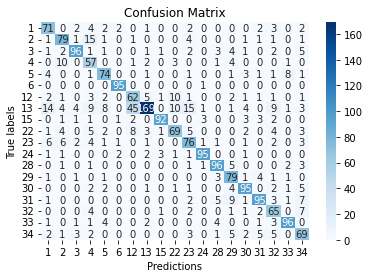

In [484]:
def display_confusion_matrix(conf_matrix,y_test_flat):
    labels = np.unique(y_test_flat)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predictions')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)
display_confusion_matrix(conf_matrix,y_test_flat)

## 3. Demo

In [486]:
def recognition(index_tab):
    recognized_captchas = []

    for sample in index_tab:
        captcha = ""
        for index in sample:
            recognized_ch = SYMBOLS[index]
            captcha += recognized_ch
        recognized_captchas.append(captcha)
        
    return recognized_captchas


pred_captchas = recognition(y_pred_t)
captchas_to_found = recognition(y_test_t)
for i in range (RECOGNIZED_CAPTCHAS_TO_DISPLAY):
    print(f"Captchas to find :{captchas_to_found[i]}")
    print(f"Captchas recognized:{pred_captchas[i]}")

Captchas to find :xcf86
Captchas recognized:xcf88
Captchas to find :c84xc
Captchas recognized:b84xc
Captchas to find :pnn5m
Captchas recognized:pmf5w
Captchas to find :wgc25
Captchas recognized:wg625
Captchas to find :2fgx8
Captchas recognized:2bg48
